## Set up

Let's ensure that we have the files and packages needed. Arrange your downloaded files in the following manner.

```
src
│   doe.py
│   inverse.py

└───analyses
│   │   allowable_drift.ipynb
│   
└───data
    │   structural_db_drift_allow_loss.pickle
    │   structural_db_drift_allow_max_loss.pickle
    │   structural_db_drift_allow.pickle
    |   braceShapes.csv
    |   variable_list.csv

```

Make sure you have some installations of the following:

    - Pandas 2.2.0+
    - Numpy 1.22.4+
    - Scipy 1.12.0+
    - Scikit-learn
    - Seaborn
    - Matplotlib

Then, change the following file locations to match yours:
-   `path_to_loss_file`
-   `path_to_max_file`
-   `path_to_braceShapes`


In [1]:
# path management and package import

# this is to ensure that the .py files are recognized
import sys
sys.path.insert(1, '../')


###################### YOUR CODE HERE #############################################
# <change these to your paths> (it should be something like ../data/whatever.pickle)
path_to_loss_file = '../../data/loss/structural_db_drift_allow_loss.pickle'
path_to_max_file = '../../data/loss/structural_db_drift_allow_max_loss.pickle'

# also change this to point to the directory with the brace database
# (should be ../data/, I think)
path_to_braceShapes = '../../resource/'
###################################################################################

# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP
import inverse as inv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None 

## Pre-processing

Basically, this prepares all of the variables that are used in the study and stores everything in the `df` DataFrame. You don't need to read the following stuff if it is too confusing. 

`main_obj` is the object that stores the analyses results of the 1000 points. `max_obj` is an object that stores analyses results of the same 1000 points, but assuming that everything was destroyed inside the building. This gives us a reference value so that we can calculate how much the building lost in terms of content as a percentage.

In [ ]:
main_obj = pd.read_pickle(path_to_loss_file)
max_obj = pd.read_pickle(path_to_max_file)
df = inv.preprocess_data(main_obj, max_obj, db_string=path_to_braceShapes)

Here, you can take a peek at what this DataFrame contains. In the shared files, I've included a spreadsheet that explains each variable. We won't be using most of the variables.

In [ ]:
# view a bit of the data
pd.set_option('display.max_columns', None)
df.head()

,superstructure_system,isolator_system,num_frames,S_1,T_m,k_ratio,moat_ampli,RI,L_bldg,h_bldg,zeta_e,delta_a,num_bays,num_stories,L_bay,h_story,S_s,W,W_s,w_fl,P_lc,all_w_cases,all_Plc_cases,mu_1,mu_2,R_1,R_2,T_e,k_e,Q,zeta_loop,D_m,d_bearing,d_lead,t_r,t,n_layers,N_lb,S_pad,S_2,wx,hx,h_col,hsx,Fx,Vs,T_fbe,beam,column,brace,gm_selected,scale_factor,sa_avg,sa_tm,sa_1,sa_tfb,constructed_moat,T_1,T_fb,T_ratio,gap_ratio,max_isol_disp,PID,PFV,PFA,RID,impacted,run_status,max_drift,collapse_prob,log_collapse_prob,log_drift,max_velo,max_accel,T_ratio_e,Bm,k2,k1,bldg_area,W_L,Tshift_coef,T_M_adj,replacement_cost,total_cmp_cost,cmp_replace_cost_ratio,median_cost_ratio,cmp_cost_ratio,replacement_time,total_cmp_time,cmp_replace_time_ratio,median_time_ratio,cmp_time_ratio,replacement_freq,B_50%,C_50%,D_50%,E_50%,steel_cost,steel_cost_per_sf,system
0,CBF,TFP,2.0,1.248156,3.543509,14.649668,0.559622,1.602873,84.330713,33.879726,0.139135,0.019714,3,2,28.110238,16.939863,2.2815,1955.70901,1244.542097,"[2.811023761045672, 2.811023761045672, 1.88651...","[474.11127510980117, 474.11127510980117, 318.1...","{'1.4D': [1.9677166327319702, 1.96771663273197...","{'1.4D': [331.8778925768608, 331.8778925768608...",0.040688,0.063132,15.126432,78.781224,3.543509,0.008137,0.058823,0.139137,32.859557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[711.1669126647018, 533.3751844985263]","[203.27835888609536, 406.5567177721907]","[203.27835888609536, 101.63917944304768]","[203.27835888609536, 203.27835888609536]","[53.38645763412557, 68.08531754185321]",121.471775,0.393199,"[W33X141, W30X116]","[W12X58, W12X58]","[HSS7X7X1/4, HSS6X6X3/16]",RSN4040_BAM_BAM-L,1.694723,0.840787,0.289792,1.7951,1.541415,18.388918,0.423417,0.396445,8.098314,0.680212,68.4237,"[0.4736760987624556, 1.063866321949103]","[4444.49, 7824.88, 26792.0]","[8052.096273291926, 27802.277432712217, 47517....","[0.4736760987624556, 1.063866321949103]",1,0,1.063866,1.000000e+00,-3.934852e-12,0.061910,26792.0000,47517.857143,9.011988,1.317404,0.006347,0.092977,21335.00738,853.400295,0.906033,3.210536,12801004.427965,5.639342e+06,0.440539,0.440539,1.000000,7787.277694,2889.033548,0.370994,0.370994,1.000000,1.0,4.402826e+06,777390.950352,4.021018e+05,6096.770217,97594.701159,4.574393,CBF-TFP
1,CBF,LRB,2.0,1.1376,3.052741,17.368904,0.904996,1.950874,141.727436,68.750287,0.245849,0.009152,5,5,28.345487,13.750057,2.2815,11549.833021,9541.166408,"[2.83454872055995, 2.83454872055995, 2.8345487...","[1606.93328984561, 1606.93328984561, 1606.9332...","{'1.4D': [1.984184104391965, 1.984184104391965...","{'1.4D': [1124.853302891927, 1124.853302891927...",NaN,NaN,NaN,NaN,3.052741,0.010963,0.094298,0.245852,21.354862,26.352856,6.798835,8.079017,0.336626,24.0,20.0,19.200001,3.2,"[2008.6666123070127, 2008.6666123070127, 2008....","[165.00068862241363, 330.00137724482727, 495.0...","[165.00068862241363, 165.00068862241363, 165.0...","[165.00068862241363, 165.00068862241363, 165.0...","[8.798801718075998, 43.35957038502717, 110.221...",643.841489,0.668519,"[W36X160, W36X160, W36X160, W36X135, W33X130]","[W14X145, W14X145, W14X145, W14X145, W10X26]","[HSS8X8X5/16, HSS8X8X5/16, HSS8X8X5/16, HSS8X8...",RSN577_SMART1.45_45O01EW,4.220267,0.651276,0.391553,1.130954,1.699769,19.326057,1.296037,0.793355,3.847886,0.861302,17.1235,"[0.0025096864955977526, 0.0025659892909227944,...","[35.9275, 34.9543, 33.9535, 34.0458, 34.6965, ...","[0.5083178053830227, 0.2269003623188406, 0.171...","[0.0002570352909074997, 0.0002430292887550583,...",0,0,0.002577,1.977367e-05,-1.083116e+01,-5.961145,35.9275,0.508318,4.566421,1.591699,0.006548,0.113724,120519.996738,5423.399853,1.000000,3.052741,72311998.043052,3.299165e+07,0.45624,0.012472,0.027336,43989.79881,7882.741067,0.179195,0.005621,0.031371,0.0,5.836733e+05,130851.670878,1.274696e+05,0.000000,512953.307551,4.256168,CBF-LRB
2,CBF,TFP,2.0,1.231249,3.021773,9.721468,0.853225,1.837052,227.902243,36.439439,0.125012,0.014924,8,3,28.48778,12.14648,2.2815,19477.287213,14283.343956,"[2.8487780430965977, 2

## Subset of data

The dataset contains several different steel systems. In the superstructure, there are special concentrically braced frames (CBF) and special moment resisting frames (MF). These are isolated by two types of bearings: triple friction pendulum bearings (TFP) and lead rubber bearings (LRB).

Since we might expect that the design variables affect the systems differently, we will separate the dataset into a couple of subsets to help us study them individually.

I've also found that variables might behave differently depending on whether or not they impact against the moat wall, so I've segregated those points as well, with `_i` indicating that impact occurred during the earthquake run, and `_o` indicating that impact did not occur.

In [6]:
# separate by isolators
df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

# separate by superstructure
df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

# superstructures, only without impact
df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

# every permutation: MF-TFP, MF-LRB, CBF-TFP, CBF-LRB
df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']

# permutations, separated by impact condition
df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

# Study objective

In this study, we're interested in seeing how four design parameters affect three outcomes. The inputs are:

-   `gap_ratio`: How much more displacement capacity we built compared to what we expected from the earthquake. 1.0 means that we built exactly the displacement as expected from the spectrum, whereas <1.0 means that we underconstructed  the moat.
-   `RI`: Strength reduction factor. The ratio of the elastic base shear to the design base shear (also known as $R_y$ or just $R$). 1.0 means that the steel frame is designed with forces equal to the demand from the MCE ground motion. >1.0 means we've reduced the design force (inelastic design). You can find this from CE 225 notes, CE 227 notes, or my discussion from steel when we talked about inelastic earthquake design.
-   `delta_a`: Allowable drift. Maximum drift expected under the design force $\Delta_a$. Whereas $R$ controls _strength_ of the structure, $\Delta_a$ controls the _stiffness_.
-   `T_ratio`: $T_M$/$T_{fb}$. The ratio between the isolation system period and the fixed-base structure period. Basically, how much are we isolating the building. 1.0 means that the structure and the isolators are equally stiff (no isolation), and >1.0 means that some isolation effect is felt.

The outcomes are:
-   `cmp_cost_ratio`: Compared to the worst case scenario, how much do the repairs cost after an MCE
-   `cmp_time_ratio`: Compared to the worst case scenario, how long will the repairs take after an MCE
-   `replacement_freq`: What is the probability that the building will need to be demolished and rebuilt (either from collapse or too much permanent damage)?

My hypothesis is that different superstructures have different governing strength or stiffness, which varies according to their moat gap ratio. So, let's say a designer want for their building to cost no more than 10% of replacement cost. What are the design inputs needed?

## Visualize data

Now we can finally get to a bit of the data analysis. 


So. Let's see what effects the design variables have on the outcomes. Try making some plots to help you visualize the relationships between the variable. You could make your own plots, or the block below has pre-coded scatterplot-histograms, in case you need inspiration.

Some questions for you to try to answer via these plots:

1. What are the relationships between each input variable and each output variable? Which of these are significant?
2. Are these relationshps the same or different within each system? CBFs vs MFs? TFPs vs LRBs?
3. Do these relationships change if you condition on the "impact" status of the building?
4. Are there any correlations among the inputs themselves?
5. Do you think the relationships are linear? Nonlinear? Quadratic? etc.
6. Are there parts of the data that have less variance than others?

Try to explain some of these results in a physical manner as well. For example, below I show the relationship between $\Delta_a$ and repair cost, only for buildings that do not experience impact against  the moat wall. We can see that lower allowable drift lowers cost, but much more in MFs than CBFs (but why?).


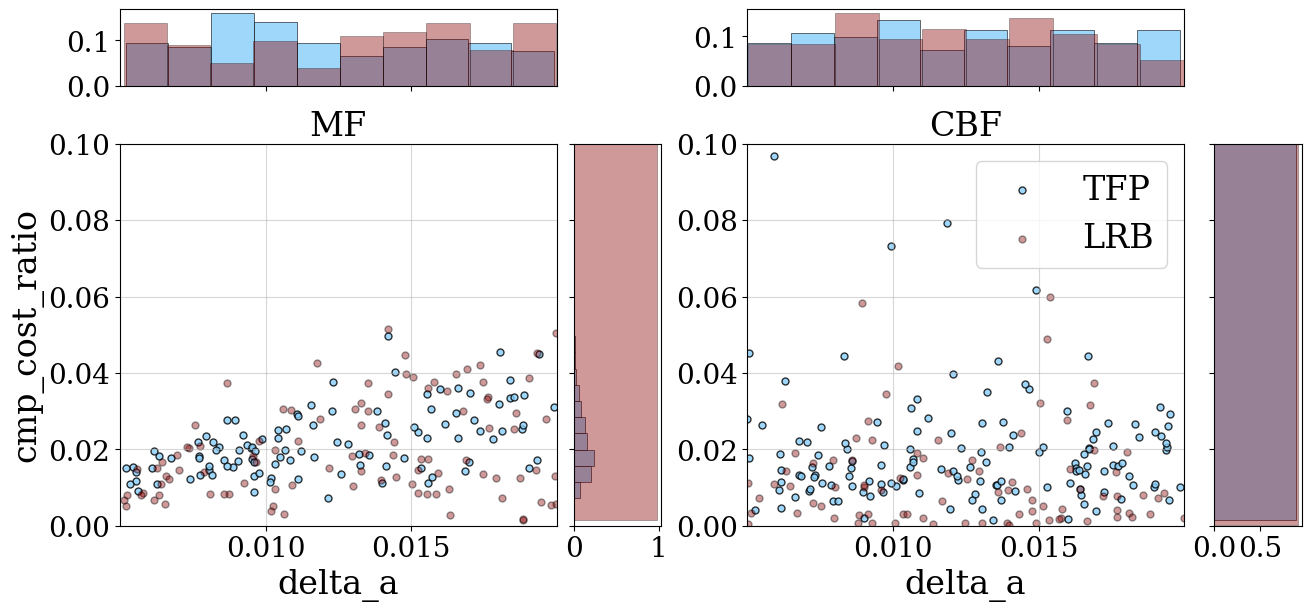

In [ ]:
#%%

###################### YOUR CODE HERE #############################################
# choose your x and y variables. These are column names of df
xvar = 'delta_a'
yvar = 'cmp_cost_ratio'

# dataset used for each plot. you can change these to change the content of the scatter.
left_points_blue = df_mf_tfp_o.copy()
left_points_red = df_mf_lrb_o.copy()
right_points_blue = df_cbf_tfp_o.copy()
right_points_red = df_cbf_lrb_o.copy()

# you might have to change the y-limits of the plots to see meaningful trends
# ax.set_ylim([0, 0.15])
###################################################################################

def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # ax_histx.grid(True)
    # ax_histy.grid(True)
    
    # the scatter plot:
    ax.grid(True, alpha=0.5)
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
                label=label)

    n_bins = 10
    ax_histx.hist(x, bins=n_bins, alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
    
    ax_histy.hist(y, bins=n_bins, orientation='horizontal', alpha = alpha, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='black', linewidth=0.5)
  

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
axis_font = 24
subt_font = 22
import matplotlib as mpl
label_size = 20
title_font = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

plt.close('all')
# Start with a square Figure.
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals.
scatter_hist(left_points_blue[xvar], left_points_blue[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
             label='TFP')
scatter_hist(left_points_red[xvar], left_points_red[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
             label='LRB')
# ax.legend(fontsize=axis_font)

ax.set_title(r'MF', fontsize=title_font)

ax.set_xlabel(xvar, fontsize=axis_font)
ax.set_ylabel(yvar, fontsize=axis_font)
ax.set_xlim([df[xvar].min(), df[xvar].max()])
# ax.set_ylim([df[yvar].min(), df[yvar].max()])
ax.set_ylim([0, 0.1])

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)

# Draw the scatter plot and marginals.

scatter_hist(right_points_blue[xvar], right_points_blue[yvar], 'lightskyblue', 0.8, ax, ax_histx, ax_histy,
              label='TFP')
scatter_hist(right_points_red[xvar], right_points_red[yvar], 'darkred', 0.4, ax, ax_histx, ax_histy,
              label='LRB')

ax.set_xlim([df[xvar].min(), df[xvar].max()])
# ax.set_ylim([df[yvar].min(), df[yvar].max()])
ax.set_ylim([0, 0.1])

ax.set_title(r'CBF', fontsize=title_font)
ax.set_xlabel(xvar, fontsize=axis_font)

ax.legend(fontsize=axis_font)

I understand that this dataset is given to you almost as a black box. Please feel free to ask me any questions at any time to explain things in more details!

Now you try it. Make any plots that you might think help you understand these relationships better (if any). Feel free to refer to `variable_list.csv` to find relationships in the data points that you might want to explore.

I sometimes find good inspiration in the Seaborn and Matplotlib galleries.

https://matplotlib.org/stable/gallery/index.html
https://seaborn.pydata.org/examples/index.html

You can access any variable with `df[your_var]`.

In [13]:
################ YOUR PLOTS HERE ... (maybe) #################

# End of tasks for Week of March 3rd

## Gaussian process models

In [ ]:
cost_var = 'cmp_cost_ratio'
time_var = 'cmp_time_ratio'
repl_var= 'replacement_freq'
covariate_list = ['gap_ratio', 'RI', 'T_ratio', 'zeta_e']   

Impact classification models

In [14]:
#%% impact classification model
# for each system, make separate impact classification model

mdl_all = GP(df)
mdl_all.set_covariates(covariate_list)

mdl_impact_cbf_lrb = GP(df_cbf_lrb)
mdl_impact_cbf_lrb.set_covariates(covariate_list)
mdl_impact_cbf_lrb.set_outcome('impacted')
mdl_impact_cbf_lrb.test_train_split(0.2)

mdl_impact_cbf_tfp = GP(df_cbf_tfp)
mdl_impact_cbf_tfp.set_covariates(covariate_list)
mdl_impact_cbf_tfp.set_outcome('impacted')
mdl_impact_cbf_tfp.test_train_split(0.2)

mdl_impact_mf_lrb = GP(df_mf_lrb)
mdl_impact_mf_lrb.set_covariates(covariate_list)
mdl_impact_mf_lrb.set_outcome('impacted')
mdl_impact_mf_lrb.test_train_split(0.2)

mdl_impact_mf_tfp = GP(df_mf_tfp)
mdl_impact_mf_tfp.set_covariates(covariate_list)
mdl_impact_mf_tfp.set_outcome('impacted')
mdl_impact_mf_tfp.test_train_split(0.2)

print('======= impact classification per system ========')
import time
t0 = time.time()

mdl_impact_cbf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_cbf_tfp.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_tfp.fit_gpc(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPC training for impact done for 4 models in %.3f s" % tp)

# density estimation model to enable constructability 
print('======= Density estimation per system ========')

t0 = time.time()

mdl_impact_mf_lrb.fit_kde()
mdl_impact_cbf_lrb.fit_kde()
mdl_impact_mf_tfp.fit_kde()
mdl_impact_cbf_tfp.fit_kde()

tp = time.time() - t0

print("KDE training done for 4 models in %.3f s" % tp)


impact_classification_mdls = {'mdl_impact_cbf_lrb': mdl_impact_cbf_lrb,
                        'mdl_impact_cbf_tfp': mdl_impact_cbf_tfp,
                        'mdl_impact_mf_lrb': mdl_impact_mf_lrb,
                        'mdl_impact_mf_tfp': mdl_impact_mf_tfp}

======= impact classification per system ========
The GP training score is 0.760
The GP testing score is 0.750
The GP training score is 0.758
The GP testing score is 0.733
The GP training score is 0.797
The GP testing score is 0.864
The GP training score is 0.760
The GP testing score is 0.643
GPC training for impact done for 4 models in 1.081 s
======= Density estimation per system ========
KDE training done for 4 models in 3.855 s


Cost regression models

In [ ]:
mdl_cost_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_cost_cbf_lrb_i.set_covariates(covariate_list)
mdl_cost_cbf_lrb_i.set_outcome(cost_var)
mdl_cost_cbf_lrb_i.test_train_split(0.2)

mdl_cost_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_cost_cbf_lrb_o.set_covariates(covariate_list)
mdl_cost_cbf_lrb_o.set_outcome(cost_var)
mdl_cost_cbf_lrb_o.test_train_split(0.2)

mdl_cost_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_cost_cbf_tfp_i.set_covariates(covariate_list)
mdl_cost_cbf_tfp_i.set_outcome(cost_var)
mdl_cost_cbf_tfp_i.test_train_split(0.2)

mdl_cost_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_cost_cbf_tfp_o.set_covariates(covariate_list)
mdl_cost_cbf_tfp_o.set_outcome(cost_var)
mdl_cost_cbf_tfp_o.test_train_split(0.2)

mdl_cost_mf_lrb_i = GP(df_mf_lrb_i)
mdl_cost_mf_lrb_i.set_covariates(covariate_list)
mdl_cost_mf_lrb_i.set_outcome(cost_var)
mdl_cost_mf_lrb_i.test_train_split(0.2)

mdl_cost_mf_lrb_o = GP(df_mf_lrb_o)
mdl_cost_mf_lrb_o.set_covariates(covariate_list)
mdl_cost_mf_lrb_o.set_outcome(cost_var)
mdl_cost_mf_lrb_o.test_train_split(0.2)

mdl_cost_mf_tfp_i = GP(df_mf_tfp_i)
mdl_cost_mf_tfp_i.set_covariates(covariate_list)
mdl_cost_mf_tfp_i.set_outcome(cost_var)
mdl_cost_mf_tfp_i.test_train_split(0.2)

mdl_cost_mf_tfp_o = GP(df_mf_tfp_o)
mdl_cost_mf_tfp_o.set_covariates(covariate_list)
mdl_cost_mf_tfp_o.set_outcome(cost_var)
mdl_cost_mf_tfp_o.test_train_split(0.2)

print('======= cost regression per system per impact ========')
import time
t0 = time.time()

mdl_cost_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for cost done for 8 models in %.3f s" % tp)

cost_regression_mdls = {'mdl_cost_cbf_lrb_i': mdl_cost_cbf_lrb_i,
                        'mdl_cost_cbf_lrb_o': mdl_cost_cbf_lrb_o,
                        'mdl_cost_cbf_tfp_i': mdl_cost_cbf_tfp_i,
                        'mdl_cost_cbf_tfp_o': mdl_cost_cbf_tfp_o,
                        'mdl_cost_mf_lrb_i': mdl_cost_mf_lrb_i,
                        'mdl_cost_mf_lrb_o': mdl_cost_mf_lrb_o,
                        'mdl_cost_mf_tfp_i': mdl_cost_mf_tfp_i,
                        'mdl_cost_mf_tfp_o': mdl_cost_mf_tfp_o}

Downtime regression models

In [ ]:
#%% regression models: time
# goal: E[time|sys=sys, impact=impact]

mdl_time_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_time_cbf_lrb_i.set_covariates(covariate_list)
mdl_time_cbf_lrb_i.set_outcome(time_var)
mdl_time_cbf_lrb_i.test_train_split(0.2)

mdl_time_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_time_cbf_lrb_o.set_covariates(covariate_list)
mdl_time_cbf_lrb_o.set_outcome(time_var)
mdl_time_cbf_lrb_o.test_train_split(0.2)

mdl_time_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_time_cbf_tfp_i.set_covariates(covariate_list)
mdl_time_cbf_tfp_i.set_outcome(time_var)
mdl_time_cbf_tfp_i.test_train_split(0.2)

mdl_time_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_time_cbf_tfp_o.set_covariates(covariate_list)
mdl_time_cbf_tfp_o.set_outcome(time_var)
mdl_time_cbf_tfp_o.test_train_split(0.2)

mdl_time_mf_lrb_i = GP(df_mf_lrb_i)
mdl_time_mf_lrb_i.set_covariates(covariate_list)
mdl_time_mf_lrb_i.set_outcome(time_var)
mdl_time_mf_lrb_i.test_train_split(0.2)

mdl_time_mf_lrb_o = GP(df_mf_lrb_o)
mdl_time_mf_lrb_o.set_covariates(covariate_list)
mdl_time_mf_lrb_o.set_outcome(time_var)
mdl_time_mf_lrb_o.test_train_split(0.2)

mdl_time_mf_tfp_i = GP(df_mf_tfp_i)
mdl_time_mf_tfp_i.set_covariates(covariate_list)
mdl_time_mf_tfp_i.set_outcome(time_var)
mdl_time_mf_tfp_i.test_train_split(0.2)

mdl_time_mf_tfp_o = GP(df_mf_tfp_o)
mdl_time_mf_tfp_o.set_covariates(covariate_list)
mdl_time_mf_tfp_o.set_outcome(time_var)
mdl_time_mf_tfp_o.test_train_split(0.2)

print('======= downtime regression per system per impact ========')
import time
t0 = time.time()

mdl_time_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for time done for 8 models in %.3f s" % tp)

time_regression_mdls = {'mdl_time_cbf_lrb_i': mdl_time_cbf_lrb_i,
                        'mdl_time_cbf_lrb_o': mdl_time_cbf_lrb_o,
                        'mdl_time_cbf_tfp_i': mdl_time_cbf_tfp_i,
                        'mdl_time_cbf_tfp_o': mdl_time_cbf_tfp_o,
                        'mdl_time_mf_lrb_i': mdl_time_mf_lrb_i,
                        'mdl_time_mf_lrb_o': mdl_time_mf_lrb_o,
                        'mdl_time_mf_tfp_i': mdl_time_mf_tfp_i,
                        'mdl_time_mf_tfp_o': mdl_time_mf_tfp_o}

Replacement probability regression model

In [ ]:
#%% regression models: repl
# goal: E[repl|sys=sys, impact=impact]

mdl_repl_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_repl_cbf_lrb_i.set_covariates(covariate_list)
mdl_repl_cbf_lrb_i.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_i.test_train_split(0.2)

mdl_repl_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_repl_cbf_lrb_o.set_covariates(covariate_list)
mdl_repl_cbf_lrb_o.set_outcome('replacement_freq')
mdl_repl_cbf_lrb_o.test_train_split(0.2)

mdl_repl_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_repl_cbf_tfp_i.set_covariates(covariate_list)
mdl_repl_cbf_tfp_i.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_i.test_train_split(0.2)

mdl_repl_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_repl_cbf_tfp_o.set_covariates(covariate_list)
mdl_repl_cbf_tfp_o.set_outcome('replacement_freq')
mdl_repl_cbf_tfp_o.test_train_split(0.2)

mdl_repl_mf_lrb_i = GP(df_mf_lrb_i)
mdl_repl_mf_lrb_i.set_covariates(covariate_list)
mdl_repl_mf_lrb_i.set_outcome('replacement_freq')
mdl_repl_mf_lrb_i.test_train_split(0.2)

mdl_repl_mf_lrb_o = GP(df_mf_lrb_o)
mdl_repl_mf_lrb_o.set_covariates(covariate_list)
mdl_repl_mf_lrb_o.set_outcome('replacement_freq')
mdl_repl_mf_lrb_o.test_train_split(0.2)

mdl_repl_mf_tfp_i = GP(df_mf_tfp_i)
mdl_repl_mf_tfp_i.set_covariates(covariate_list)
mdl_repl_mf_tfp_i.set_outcome('replacement_freq')
mdl_repl_mf_tfp_i.test_train_split(0.2)

mdl_repl_mf_tfp_o = GP(df_mf_tfp_o)
mdl_repl_mf_tfp_o.set_covariates(covariate_list)
mdl_repl_mf_tfp_o.set_outcome('replacement_freq')
mdl_repl_mf_tfp_o.test_train_split(0.2)

t0 = time.time()

print('======= replacement regression per system per impact ========')

mdl_repl_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_repl_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for replacement done for 8 models in %.3f s" % tp)

repl_regression_mdls = {'mdl_repl_cbf_lrb_i': mdl_repl_cbf_lrb_i,
                        'mdl_repl_cbf_lrb_o': mdl_repl_cbf_lrb_o,
                        'mdl_repl_cbf_tfp_i': mdl_repl_cbf_tfp_i,
                        'mdl_repl_cbf_tfp_o': mdl_repl_cbf_tfp_o,
                        'mdl_repl_mf_lrb_i': mdl_repl_mf_lrb_i,
                        'mdl_repl_mf_lrb_o': mdl_repl_mf_lrb_o,
                        'mdl_repl_mf_tfp_i': mdl_repl_mf_tfp_i,
                        'mdl_repl_mf_tfp_o': mdl_repl_mf_tfp_o}

Helper functions:

1) A tool to make 2d plotting spaces
2) 

In [ ]:
def make_2D_plotting_space(X, res, x_var='gap_ratio', y_var='RI', 
                           all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                           third_var_set = None, fourth_var_set = None,
                           x_bounds=None, y_bounds=None):
    
    if x_bounds == None:
        x_min = min(X[x_var])
        x_max = max(X[x_var])
    else:
        x_min = x_bounds[0]
        x_max = x_bounds[1]
    if y_bounds == None:
        y_min = min(X[y_var])
        y_max = max(X[y_var])
    else:
        y_min = y_bounds[0]
        y_max = y_bounds[1]
    xx, yy = np.meshgrid(np.linspace(x_min,
                                     x_max,
                                     res),
                         np.linspace(y_min,
                                     y_max,
                                     res))

    rem_vars = [i for i in all_vars if i not in [x_var, y_var]]
    third_var = rem_vars[0]
    fourth_var = rem_vars[-1]
       
    xx = xx
    yy = yy
    
    if third_var_set is None:
        third_var_val= X[third_var].median()
    else:
        third_var_val = third_var_set
    if fourth_var_set is None:
        fourth_var_val = X[fourth_var].median()
    else:
        fourth_var_val = fourth_var_set
    
    
    X_pl = pd.DataFrame({x_var:xx.ravel(),
                         y_var:yy.ravel(),
                         third_var:np.repeat(third_var_val,
                                             res*res),
                         fourth_var:np.repeat(fourth_var_val, 
                                              res*res)})
    X_plot = X_pl[all_vars]
                         
    return(X_plot)